<a href="https://colab.research.google.com/github/yablockoo/GB/blob/AI/HW5AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучить нейронную сеть LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

np.random.seed(42)

In [2]:
dataframe = pd.read_csv('/content/drive/MyDrive/data/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [3]:
dataset[:10]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.]], dtype=float32)

In [4]:
#нормализуем датасет
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#разобьём на train и test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(f'train shape: {train.shape}')
print(f'test shape: {test.shape}')

train shape: (96, 1)
test shape: (48, 1)


In [5]:
#функция разбития временного ряда
def create_dataset(dataset, look_back=1):
	X, y = [], []

	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i + look_back), 0]
		X.append(a)
		y.append(dataset[i + look_back, 0])
  
	return np.array(X), np.array(y)


In [6]:
#изменим размерность X=t и Y=t+1
look_back = 3
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

#изменим размерность input в вид [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))


In [7]:
print(f'X train shape: {x_train.shape}')
print(f'X test shape: {x_test.shape}')

X train shape: (92, 1, 3)
X test shape: (44, 1, 3)


In [8]:
# create and fit the LSTM network
neurons = 100
epochs = 150
batch_size = 10

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model = Sequential()
model.add(LSTM(neurons, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=opt)
hh = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

Epoch 1/150
10/10 - 4s - loss: 0.0426 - 4s/epoch - 410ms/step
Epoch 2/150
10/10 - 0s - loss: 0.0214 - 48ms/epoch - 5ms/step
Epoch 3/150
10/10 - 0s - loss: 0.0105 - 53ms/epoch - 5ms/step
Epoch 4/150
10/10 - 0s - loss: 0.0068 - 70ms/epoch - 7ms/step
Epoch 5/150
10/10 - 0s - loss: 0.0066 - 57ms/epoch - 6ms/step
Epoch 6/150
10/10 - 0s - loss: 0.0062 - 48ms/epoch - 5ms/step
Epoch 7/150
10/10 - 0s - loss: 0.0057 - 38ms/epoch - 4ms/step
Epoch 8/150
10/10 - 0s - loss: 0.0052 - 49ms/epoch - 5ms/step
Epoch 9/150
10/10 - 0s - loss: 0.0049 - 36ms/epoch - 4ms/step
Epoch 10/150
10/10 - 0s - loss: 0.0047 - 49ms/epoch - 5ms/step
Epoch 11/150
10/10 - 0s - loss: 0.0044 - 48ms/epoch - 5ms/step
Epoch 12/150
10/10 - 0s - loss: 0.0041 - 49ms/epoch - 5ms/step
Epoch 13/150
10/10 - 0s - loss: 0.0039 - 56ms/epoch - 6ms/step
Epoch 14/150
10/10 - 0s - loss: 0.0038 - 79ms/epoch - 8ms/step
Epoch 15/150
10/10 - 0s - loss: 0.0037 - 51ms/epoch - 5ms/step
Epoch 16/150
10/10 - 0s - loss: 0.0036 - 77ms/epoch - 8ms/step
E

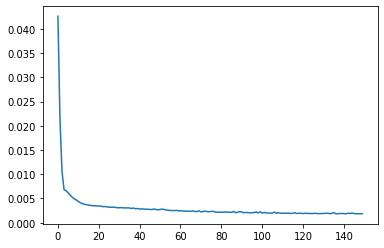

In [9]:
plt.plot(hh.history['loss'])
plt.show()


In [10]:
#сделаем предсказания
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)
print(f'train_predict: \n{train_predict[:5]} \n')
print(f'test_predict: \n{test_predict[:5]}')

train_predict: 
[[0.066802  ]
 [0.05922091]
 [0.04302812]
 [0.07174969]
 [0.09664381]] 

test_predict: 
[[0.47983736]
 [0.45194995]
 [0.4580839 ]
 [0.6035743 ]
 [0.67808586]]


In [11]:
# перевернём предсказания
trainPredict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

In [17]:
# вычислим среднеквадратичную метрику
train_score = math.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_score = math.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))

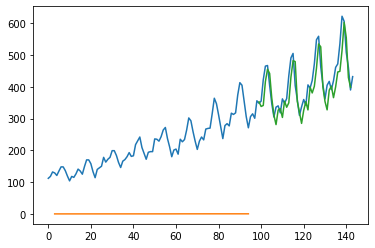

Train Score: 226.70 RMSE
Test Score: 48.12 RMSE


In [18]:
#визуализация
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(trainPredict)+look_back, :] = train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')

train_predict прилёг(

Основную прибавку в качестве дало увеличение количества нейронов. Немного дало добавление количества эпох и увеличение батча.